In [39]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

# Download resources if not already done
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("vader_lexicon")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jaclyn.bnv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jaclyn.bnv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jaclyn.bnv\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [40]:
# Read in iris_raw.csv
df = pd.read_csv("../data/customer_raw.csv")

In [41]:
# tokenize and clean
stop_words = set(stopwords.words("english"))

def preprocess_and_tokenize(text):
    # lowercase
    text = str(text).lower()
    # tokenize
    tokens = word_tokenize(text)
    # remove stopwords and keep only alphabetic tokens
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return tokens

df["tokens"] = df["feedback_text"].fillna("").apply(preprocess_and_tokenize)

# sentiment analysis with vader
sia = SentimentIntensityAnalyzer()
scores = df["feedback_text"].fillna("").apply(sia.polarity_scores)

# Expand into separate columns (neg, neu, pos, compound)
df = pd.concat([df, scores.apply(pd.Series)], axis=1)

# Label using compound score
df["sentiment_new"] = df["compound"].apply(
    lambda x: "Positive" if x > 0.05 else ("Negative" if x < -0.05 else "Neutral")
)

# Preview
df[["feedback_text", "tokens", "compound", "sentiment_new"]].head()

,feedback_text,tokens,compound,sentiment_new
0,"Terrible experience, will not buy again.","[terrible, experience, buy]",-0.4767,Negative
1,Excellent customer service.,"[excellent, customer, service]",0.5719,Positive
2,Product quality could be better.,"[product, quality, could, better]",0.4404,Positive
3,"Delivery was late, not happy.","[delivery, late, happy]",-0.4585,Negative
4,"Delivery was late, not happy.","[delivery, late, happy]",-0.4585,Negative


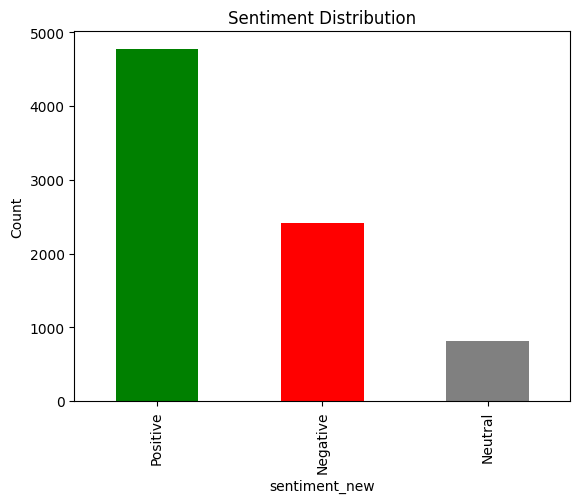

In [42]:
df['sentiment_new'].value_counts().plot(kind='bar', color=['green','red','gray'])
plt.title("Sentiment Distribution")
plt.ylabel("Count")
plt.show()


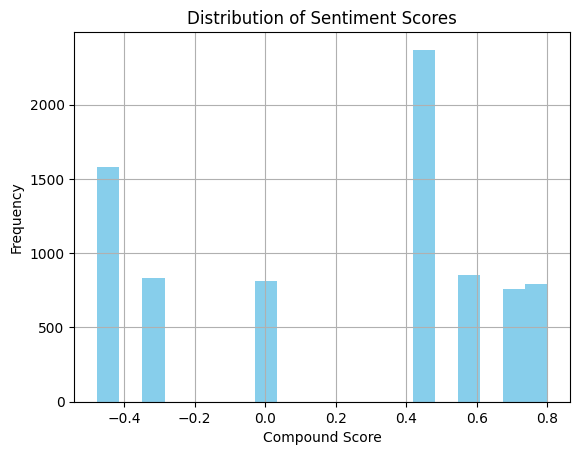

In [43]:
df['compound'].hist(bins=20, color='skyblue')
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Compound Score")
plt.ylabel("Frequency")
plt.show()


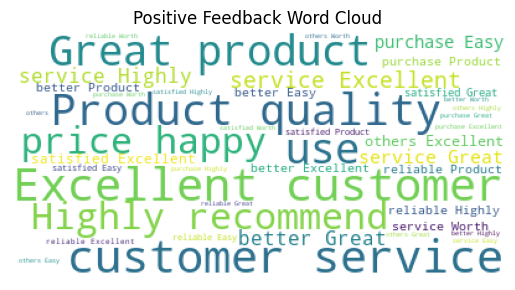

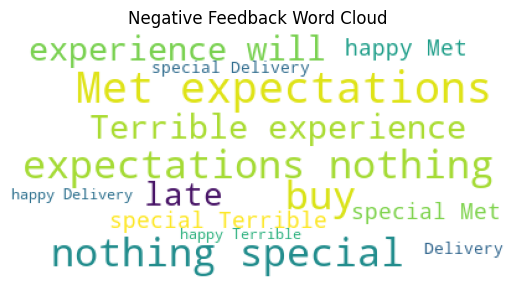

In [44]:

text_pos = " ".join(df[df['sentiment_new']=="Positive"]['feedback_text'])
text_neg = " ".join(df[df['sentiment_new']=="Negative"]['feedback_text'])

wc = WordCloud(background_color="white", max_words=100)
plt.imshow(wc.generate(text_pos))
plt.title("Positive Feedback Word Cloud")
plt.axis("off")
plt.show()

wc = WordCloud(background_color="white", max_words=100)
plt.imshow(wc.generate(text_neg))
plt.title("Negative Feedback Word Cloud")
plt.axis("off")
plt.show()


In [45]:
# Convert date columns to datetime
# Convert to datetime
df["sale_date"] = pd.to_datetime(df["sale_date"], errors="coerce")
df["last_purchase_date"] = pd.to_datetime(df["last_purchase_date"], errors="coerce")

# Derive features (example)
df["days_since_last_purchase"] = (pd.Timestamp("today") - df["last_purchase_date"]).dt.days
df["sale_year"] = df["sale_date"].dt.year
df["sale_month"] = df["sale_date"].dt.month


today = df["sale_date"].max()

# Helper function
def purchases_in_last_months(customer_df, months):
    cutoff = today - DateOffset(months=months)
    return (customer_df["sale_date"] >= cutoff).sum()

# Group by customer and calculate frequencies
freq_features = df.groupby("customer_id").apply(
    lambda g: pd.Series({
        "freq_3m": purchases_in_last_months(g, 3),
        "freq_6m": purchases_in_last_months(g, 6),
        "freq_12m": purchases_in_last_months(g, 12)
    })
).reset_index()

aov_features = df.groupby("customer_id")["total_value"].mean().reset_index()
aov_features.rename(columns={"total_value": "avg_order_value"}, inplace=True)

df = df.merge(freq_features, on="customer_id", how="left")
df = df.merge(aov_features, on="customer_id", how="left")



C:\Users\jaclyn.bnv\AppData\Local\Temp\ipykernel_55448\1188510780.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  freq_features = df.groupby("customer_id").apply(


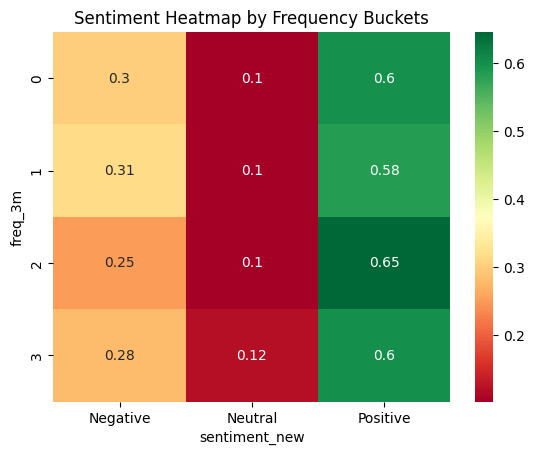

In [46]:
sent_heatmap = pd.crosstab(df['freq_3m'], df['sentiment_new'], normalize='index')
sns.heatmap(sent_heatmap, annot=True, cmap="RdYlGn")
plt.title("Sentiment Heatmap by Frequency Buckets")
plt.show()


In [47]:
# one hot encode categorical variables
categorical_cols = ['gender', 'region', 'segment', 'category', 'product_name', 'sentiment_new']
ohe = OneHotEncoder(sparse_output=False, drop='first')
X_categorical = ohe.fit_transform(df[categorical_cols])
X_numerical = df.drop(columns=categorical_cols, errors="ignore")
# Combine numerical and categorical features
df = pd.concat([X_numerical, pd.DataFrame(X_categorical, columns=ohe.get_feature_names_out(categorical_cols))], axis=1)
df.head()

,sale_id,customer_id,product_id,price,quantity,sale_date,total_value,age,churn,tenure_months,...,product_name_Laptop,product_name_Monitor,product_name_Notebook,product_name_Office Chair,product_name_Pen Pack,product_name_Printer,product_name_Projector,product_name_Smartphone,sentiment_new_Neutral,sentiment_new_Positive
0,S000001,CUST01553,P004,12000,2,2020-01-07,24000,40,1,37,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,S000002,CUST00161,P010,45000,2,2023-11-10,90000,50,0,44,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,S000003,CUST00627,P010,45000,4,2022-07-04,180000,33,0,25,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,S000004,CUST01291,P009,12000,1,2023-10-18,12000,41,0,56,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,S000005,CUST01456,P004,12000,4,2023-09-13,48000,60,0,52,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# export the cleaned and scaled datasets
df.to_csv("../data/customer_prepped.csv", index=False)